In [208]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
import uncertainties.unumpy as unp
import uncertainties as unc

### Functions

In [4]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [116]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [6]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [323]:
dfr = pd.read_json('../dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [324]:
dfp[dfp.denominazione_provincia == 'Bergamo'].tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
1584,2020-03-07 18:00:00,ITA,3,Lombardia,16,Bergamo,BG,45.694414,9.668425,761.0
1712,2020-03-08 18:00:00,ITA,3,Lombardia,16,Bergamo,BG,45.694414,9.668425,997.0
1840,2020-03-09 18:00:00,ITA,3,Lombardia,16,Bergamo,BG,45.694414,9.668425,1245.0
1968,2020-03-10 18:00:00,ITA,3,Lombardia,16,Bergamo,BG,45.694414,9.668425,1472.0
2096,2020-03-11 17:00:00,ITA,3,Lombardia,16,Bergamo,BG,45.694414,9.668425,1815.0


In [325]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
12,2020-03-07 18:00:00,ITA,2651,567,3218,1843,5061,1145,589,233,5883,42062
13,2020-03-08 18:00:00,ITA,3557,650,4207,2180,6387,1326,622,366,7375,49937
14,2020-03-09 18:00:00,ITA,4316,733,5049,2936,7985,1598,724,463,9172,53826
15,2020-03-10 18:00:00,ITA,5038,877,5915,2599,8514,529,1004,631,10149,60761
16,2020-03-11 17:00:00,ITA,5838,1028,6866,3724,10590,2076,1045,827,12462,73154


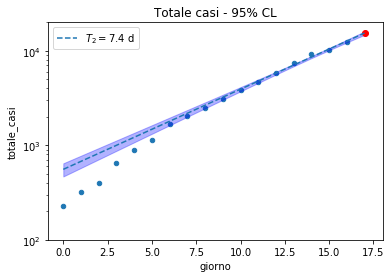

In [332]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 6

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim=[10**2,2*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi.png', dpi = 300)

In [330]:
exponential(17, *popt)

15408.661482946965

### Province

In [ ]:
provincia = 'RM'

fig, ax = plt.subplots()

x = np.arange()
px = np.arange(18)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(provincia), dpi = 300)

In [25]:
dfp[dfp.sigla_provincia == provincia].to_csv('filename.csv')

## Analisi Province

In [336]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)

In [338]:
dfp['data'] = pd.to_datetime(dfp['data'])
time = max(dfp.loc[:,'data'].values) + np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')]
df_forecast['data'] = time
df_forecast['std'] = 0.
df_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,std
2048,2020-03-12 17:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,9.0,0.0
2049,2020-03-12 17:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,6.0,0.0
2050,2020-03-12 17:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,18.0,0.0
2051,2020-03-12 17:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,5.0,0.0
2053,2020-03-12 17:00:00,ITA,17,Basilicata,77,Matera,MT,40.667512,16.597924,3.0,0.0


In [339]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr]
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp['giorno'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].giorno.values - min(df_temp[df_temp.totale_casi > 0].giorno.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Ema

In [340]:
df_forecast.to_csv('forecast_province_2020.03.12.csv')